In [233]:
## importing the necessary dependencies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib

from obspy.geodetics.base import gps2dist_azimuth
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

In [234]:
## importing station and event metadata
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278  ## coordinates of Columbia glacier. 

In [235]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events) ## To order the station-wise results according to total number of events recorded

In [238]:
## We will define all the functions used in subsequent analysis in this cell. 


def forest_test(X, Y, n_estimators= 100):
    
    """
    This function applies Random Forest classification on the input X[n_samples, n_features] and corresponding
    labels y. It will split X into test and training according to ratio specified and output the accuracy,
    sensitivity and specificity. 
    n_estimators - number of decision trees
    
    dur - refers to the time it took to train the model
    """
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.20, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    
    tn, fp, fn, tp = confusion_matrix(Y_Test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc, sensitivity, specificity, dur

def compute_dist(station, l=2):
    """"
    
    This function will compute the epicentral distance of each waveform at a given station and 
    stored it in an array 
    
    :station = station name
    :l = [0,1,2] for [E,N,Z]

    
    """
    

    dist_iq = []    ## container where dists will be stored. 
    dist_eq = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i]).select(channel='BHZ')[0]
        # loading the waveform whose SNR is to be computed
        string = glob('Data/icequake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:

            index = int(string.split('/')[2].split('icequake')[1].split('_')[0]) # we are trying to find the position of this waveform in the USGS catalog 
            # So that we can find its position in USGS catalog. Once we find its position in the catalog
            # We can extract event lat, lon, depth and origin time. This information is going to be useful for obspy.taup. 
    
    
            val = pd.read_csv('icequakes_catalog.csv').values[index]
            lat, lon =  val[1], val[2]
            stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            dist_iq.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(1000))

    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i]).select(channel='BHZ')[0]
        string = glob('Data/earthquake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:
            index = int(string.split('/')[2].split('earthquake')[1].split('_')[1])
            val = pd.read_csv('earthquakes_catalog.csv').values[index]
            time, lat, lon, depth = val[0], val[1], val[2], val[3]
            stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            dist_eq.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(1000))

    return np.mean(dist_iq), np.mean(dist_eq)


In [84]:
stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
stns

,#Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,AK,BAE,61.131900,-148.123400,578.0,"Barry Arm East, AK, USA",2020-09-04T00:00:00,2599-12-31T23:59:59
1,AK,BAT,61.141600,-148.175100,1027.0,"Barry Arm Top, AK, USA",2021-07-23T00:00:00,2599-12-31T23:59:59
2,AK,BAW,61.150100,-148.150100,542.0,"Barry Arm West, AK, USA",2020-09-04T00:00:00,2021-04-30T23:59:59
3,AK,EYAK,60.548698,-145.750000,133.9,"Cordova Ski Area, AK, USA",2002-10-03T00:00:00,2599-12-31T23:59:59
4,AK,FID,60.727699,-146.598694,500.0,"Fidalgo, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
5,AK,GLI,60.879200,-147.095901,430.0,"Glacier Island, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
6,AK,HIN,60.396000,-146.503494,622.9,"Hinchinbrook, AK, USA",2009-11-01T00:00:00,2599-12-31T23:59:59
7,AK,KLU,61.492400,-145.922700,1047.1,"Klutina Pass, AK, USA",2008-09-13T00:00:00,2599-12-31T23:59:59
8,AK,KNK,61.413100,-148.458500,598.0,"Knik Glacier, AK, USA",2010-06-13T00:00:00,2599-12-31T23:59:59
9,AK,M23K,61.792900,-147.726200,583.0,"Glacier View, AK, USA",2020-04-17T00:00:00,2599-12-31T23:59:59


In [86]:
dist_iq = []
dist_eq = []
for i in tqdm(range(len(stations))):
    o1, o2 = compute_dist(stations[i])
    dist_iq.append(o1)
    dist_eq.append(o2)

100%|██████████| 241/241 [00:11<00:00, 20.19it/s]

 85%|████████▌ | 448/526 [00:33<00:05, 13.37it/s]


100%|██████████| 160/160 [00:07<00:00, 20.01it/s]

 98%|█████████▊| 413/420 [00:31<00:00, 13.15it/s]


100%|██████████| 121/121 [00:06<00:00, 20.15it/s]

 11%|█         | 286/2593 [00:15<02:03, 18.69it/s]


 35%|███▍      | 896/2593 [00:47<01:31, 18.62it/s]


 58%|█████▊    | 1497/2593 [01:20<00:58, 18.79it/s]


 81%|████████  | 2106/2593 [01:52<00:26, 18.71it/s]


100%|██████████| 2593/2593 [02:18<00:00, 18.69it/s]

  5%|▌         | 110/2087 [00:08<02:36, 12.60it/s]


 34%|███▍      | 714/2087 [00:56<01:49, 12.56it/s]


 63%|██████▎   | 1312/2087 [01:44<01:01, 12.52it/s]


 91%|█████████ | 1904/2087 [02:31<00:14, 12.53it/s]


 23%|██▎       | 421/1856 [00:21<01:14, 19.17it/s]


 55%|█████▌    | 1025/1856 [00:53<00:42, 19.34it/s]


 87%|████████▋ | 1618/1856 [01:23<00:12, 19.33it/s]


100%|██████████| 1856/1856 [01:36<00:00, 19.30it/s]

 24%|██▍       | 364/1495 [00:28<01:28, 12.76it/s]


 65%|██████▍   | 969/1495 [01:16<00:41, 12.57it/s]


  3%|▎         | 68/2167 [00:03<01:51, 18.75it/s]


 17%|█▋        | 372/2167 [00:19<01:34, 19.06it/s]


 45%|████▌     | 977/2167 [00:51<01:02, 19.00it/s]


 73%|███████▎  | 1580/2167 [01:22<00:30, 18.96it/s]


100%|██████████| 2167/2167 [01:54<00:00, 18.96it/s]

  0%|          | 10/2061 [00:00<02:55, 11.67it/s]


 30%|██▉       | 617/2061 [00:51<01:56, 12.34it/s]


 59%|█████▉    | 1218/2061 [01:38<01:08, 12.33it/s]


 88%|████████▊ | 1810/2061 [02:26<00:20, 12.37it/s]


 18%|█▊        | 352/1990 [00:18<01:29, 18.26it/s]


 48%|████▊     | 956/1990 [00:51<00:55, 18.52it/s]


 78%|███████▊  | 1551/1990 [01:23<00:23, 18.82it/s]


100%|██████████| 1990/1990 [01:46<00:00, 18.62it/s]

  8%|▊         | 158/2099 [00:12<02:37, 12.31it/s]


 36%|███▋      | 762/2099 [01:02<01:50, 12.07it/s]


 65%|██████▍   | 1360/2099 [01:51<01:00, 12.19it/s]


 93%|█████████▎| 1952/2099 [02:39<00:12, 12.08it/s]


 21%|██▏       | 455/2129 [00:23<01:28, 19.02it/s]


 50%|████▉     | 1063/2129 [00:55<00:56, 18.92it/s]


 78%|███████▊  | 1657/2129 [01:26<00:24, 19.14it/s]


100%|██████████| 2129/2129 [01:51<00:00, 19.09it/s]

  6%|▌         | 124/2142 [00:09<02:40, 12.57it/s]


 34%|███▍      | 728/2142 [00:57<01:52, 12.55it/s]


 62%|██████▏   | 1326/2142 [01:46<01:05, 12.37it/s]


 90%|████████▉ | 1920/2142 [02:34<00:18, 12.32it/s]


 16%|█▌        | 376/2377 [00:19<01:44, 19.07it/s]


 42%|████▏     | 989/2377 [00:51<01:13, 18.95it/s]


 67%|██████▋   | 1583/2377 [01:23<00:42, 18.84it/s]


 92%|█████████▏| 2175/2377 [01:54<00:10, 18.64it/s]


100%|██████████| 2377/2377 [02:05<00:00, 18.90it/s]

  5%|▍         | 98/2104 [00:07<02:43, 12.30it/s]


 33%|███▎      | 702/2104 [00:56<01:49, 12.78it/s]


 62%|██████▏   | 1300/2104 [01:45<01:04, 12.45it/s]


 90%|████████▉ | 1892/2104 [02:33<00:17, 12.42it/s]


100%|██████████| 490/490 [00:24<00:00, 20.03it/s]

  3%|▎         | 32/1057 [00:02<01:17, 13.16it/s]


 60%|██████    | 638/1057 [00:47<00:32, 13.02it/s]


 58%|█████▊    | 249/431 [00:12<00:09, 19.86it/s]


100%|██████████| 431/431 [00:21<00:00, 19.97it/s]

 47%|████▋     | 464/989 [00:35<00:40, 13.06it/s]


  5%|▍         | 88/1908 [00:04<01:34, 19.30it/s]


 37%|███▋      | 703/1908 [00:36<01:02, 19.31it/s]


 68%|██████▊   | 1301/1908 [01:07<00:31, 19.41it/s]


 99%|█████████▉| 1894/1908 [01:37<00:00, 19.42it/s]


100%|██████████| 1908/1908 [01:38<00:00, 19.38it/s]

 37%|███▋      | 590/1594 [00:44<01:16, 13.04it/s]


 75%|███████▍  | 1190/1594 [01:31<00:31, 12.81it/s]


  8%|▊         | 190/2528 [00:10<02:05, 18.62it/s]


 32%|███▏      | 814/2528 [00:43<01:31, 18.74it/s]


 56%|█████▌    | 1416/2528 [01:14<00:58, 18.98it/s]


 80%|███████▉  | 2011/2528 [01:46<00:27, 18.94it/s]


100%|██████████| 2528/2528 [02:13<00:00, 18.90it/s]

  4%|▍         | 78/2021 [00:05<02:27, 13.16it/s]


 34%|███▎      | 682/2021 [00:51<01:42, 13.06it/s]


 63%|██████▎   | 1282/2021 [01:38<00:57, 12.87it/s]


 93%|█████████▎| 1874/2021 [02:24<00:11, 12.73it/s]


 19%|█▊        | 454/2432 [00:24<01:44, 18.93it/s]


 44%|████▎     | 1060/2432 [00:56<01:12, 18.89it/s]


 68%|██████▊   | 1655/2432 [01:27<00:40, 18.96it/s]


 92%|█████████▏| 2247/2432 [01:58<00:09, 18.93it/s]


100%|██████████| 2432/2432 [02:08<00:00, 18.93it/s]

 20%|██        | 418/2044 [00:32<02:04, 13.01it/s]


 50%|█████     | 1022/2044 [01:18<01:19, 12.87it/s]


 79%|███████▉  | 1614/2044 [02:04<00:33, 12.84it/s]


 43%|████▎     | 180/421 [00:09<00:12, 19.92it/s]


100%|██████████| 421/421 [00:21<00:00, 19.80it/s]

 39%|███▉      | 376/968 [00:28<00:45, 13.12it/s]


100%|██████████| 15/15 [47:49<00:00, 191.28s/it]


In [219]:
np.savetxt("Average_dist_iq.txt", dist_iq)
np.savetxt("Average_dist_eq.txt", dist_eq)

In [241]:
## Computing the accuracy, sensitivity, specificity and duration across different feature types.
acc_spec = []
sens_spec = []
speci_spec = []
dur_spec = []


acc_temp = []
sens_temp = []
speci_temp = []
dur_temp = []

acc_stat = []
sens_stat = []
speci_stat = []
dur_stat = []

acc_all = []
sens_all = []
speci_all = []
dur_all = []

acc_afs = []
sens_afs = []
speci_afs = []
dur_afs = []

for i in tqdm(range(len(stations))):
    
    # Extract statistical features
    X1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+".txt")
    y1 = np.loadtxt("tsfel_features/statistical/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X1, y1)
    acc_stat.append(o1)
    sens_stat.append(o2)
    speci_stat.append(o3)
    dur_stat.append(o4)
    
    
    # Extract temporal features
    X2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+".txt")
    y2 = np.loadtxt("tsfel_features/temporal/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X2, y2)
    acc_temp.append(o1)
    sens_temp.append(o2)
    speci_temp.append(o3)
    dur_temp.append(o4)
    
    # Extract spectral features
    X3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+".txt")
    y3 = np.loadtxt("tsfel_features/spectral/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X3, y3)
    acc_spec.append(o1)
    sens_spec.append(o2)
    speci_spec.append(o3)
    dur_spec.append(o4)
    
    
    ## Stacking all features
    X = np.loadtxt("tsfel_features/all/1min/"+stations[i]+".txt")
    #X = np.hstack([X1,X2,X3])
    y = np.loadtxt("tsfel_features/all/1min/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(X, y)
    acc_all.append(o1)
    sens_all.append(o2)
    speci_all.append(o3)
    dur_all.append(o4)
    
    Xr = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+".txt")
    yr = np.loadtxt("spectrum_features_1minute/Z_1_25/"+stations[i]+"_labels.txt")
    o1, o2, o3, o4 = forest_test(Xr, yr)
    acc_afs.append(o1)
    sens_afs.append(o2)
    speci_afs.append(o3)
    dur_afs.append(o4)
    
    
    

100%|██████████| 15/15 [04:55<00:00, 19.68s/it]


In [272]:
### run this cell to load distances, SNR and Az values for individual stations. 
dist = []
snr = []
az = []

for i in tqdm(range(len(stations))):
    dist.append(np.loadtxt("event_parameters/"+stations[i]+"_dist.txt"))
    snr.append(np.loadtxt("event_parameters/"+stations[i]+"_snr.txt"))
    az.append(np.loadtxt("event_parameters/"+stations[i]+"_az.txt"))

dist_array = [np.nanmedian(dist[i]) for i in range(len(dist))]
snr_array = [np.nanmedian(snr[i]) for i in range(len(snr))]
az_array = [np.nanmedian(az[i]) for i in range(len(az))]

100%|██████████| 15/15 [00:00<00:00, 55.21it/s]


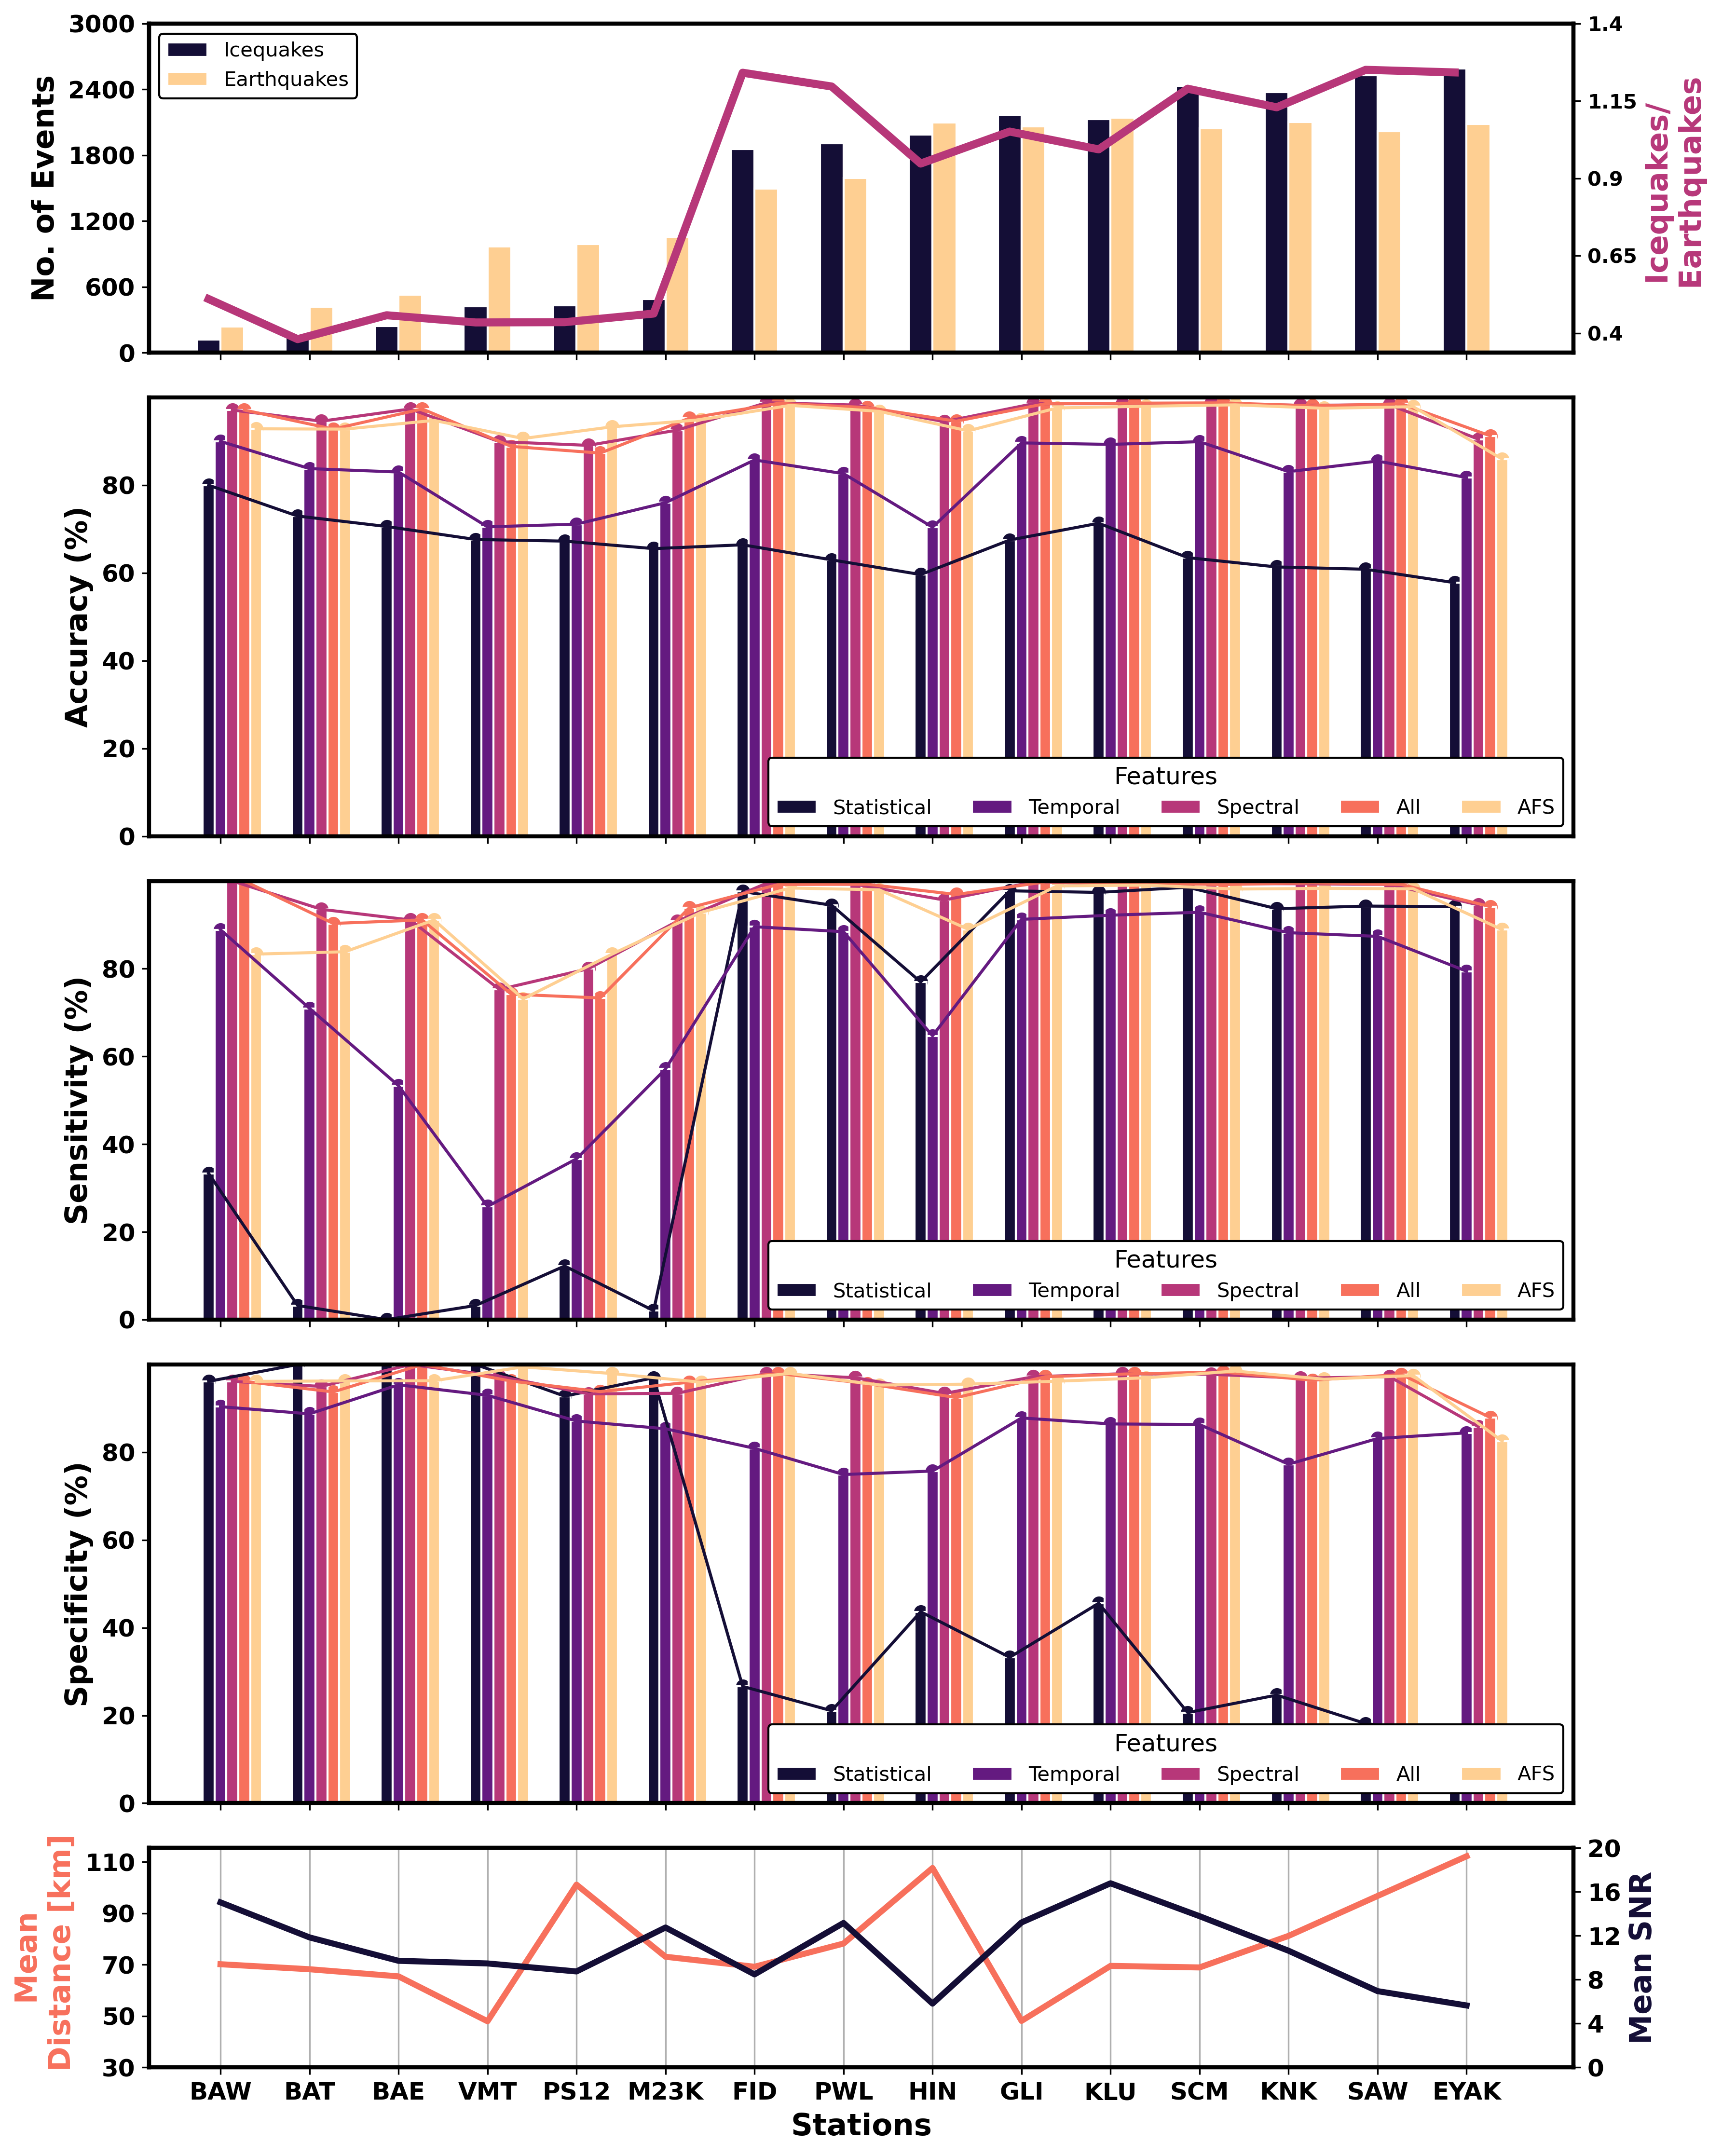

In [283]:
fig, (ax,ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, ncols=1, figsize=(12,15), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1.5,2,2,2,1]}, facecolor ='white', dpi = 300)




## Extracting colors from a colormap to maintain a constant color scheme
cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)
# set width of bar
barWidth = 0.2
# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]



ratio = np.array(no_of_icequakes)/np.array(no_of_earthquakes)

#################                
# Setting up the first axes
##############
ax.set_xlim(0,15)
ax_t = ax.twinx()
ax_t.plot(br1, ratio[order], color = c3, linewidth = 4)
ax_t.set_yticks(np.linspace(0.4,1.4,5))
ax_t.set_yticklabels([str(i) for i in np.linspace(0.4,1.4,5)],fontsize=10, fontweight='bold')
ax_t.set_ylabel('Icequakes/ \n Earthquakes', fontsize=15, fontweight='bold', color=c3)

ax.bar(br1, np.array(no_of_icequakes)[order], color =c1, width = 0.4,
     label ='Icequakes',edgecolor='w')
ax.bar(br3, np.array(no_of_earthquakes)[order], color =c5, width = 0.4,
     label ='Earthquakes',edgecolor='w')

#ax.bar(np.arange(15)+0.5, total_events[order], width=0.6)
ax.set_yticks(np.linspace(0,3000,6))
ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12, fontweight='bold')
ax.set_ylabel('No. of Events', fontsize=15, fontweight='bold')
ax.legend(loc='upper left',ncol=1, facecolor='white', framealpha=1, edgecolor='black', fontsize=10)


#########
# Setting up second axes
########


a1 = np.array(acc_stat)*100
a2 = np.array(acc_temp)*100
a3 = np.array(acc_spec)*100
a4 = np.array(acc_all)*100
a5 = np.array(acc_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax1.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax1.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax1.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax1.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax1.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax1.scatter(br1, a1[order], color=c1)
ax1.scatter(br2, a2[order], color=c2) 
ax1.scatter(br3, a3[order], color=c3) 
ax1.scatter(br4, a4[order], color=c4) 
ax1.scatter(br5, a5[order], color=c5) 

ax1.plot(br1, a1[order], color=c1)
ax1.plot(br2, a2[order], color=c2) 
ax1.plot(br3, a3[order], color=c3)
ax1.plot(br4, a4[order], color=c4)
ax1.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax1.set_title('Accuracy', fontweight ='bold', fontsize = 15)
ax1.set_ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
ax1.set_yticks(ticks = np.arange(0,100,20))
ax1.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax1.set_ylim(0,100)
ax1.set_xlim(-1,23)
ax1.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)




###############
# Setting up third axes
##############

a1 = np.array(sens_stat)*100
a2 = np.array(sens_temp)*100
a3 = np.array(sens_spec)*100
a4 = np.array(sens_all)*100
a5 = np.array(sens_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax2.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax2.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax2.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax2.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax2.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax2.scatter(br1, a1[order], color=c1)
ax2.scatter(br2, a2[order], color=c2) 
ax2.scatter(br3, a3[order], color=c3) 
ax2.scatter(br4, a4[order], color=c4) 
ax2.scatter(br5, a5[order], color=c5) 

ax2.plot(br1, a1[order], color=c1)
ax2.plot(br2, a2[order], color=c2) 
ax2.plot(br3, a3[order], color=c3)
ax2.plot(br4, a4[order], color=c4)
ax2.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax2.set_title('Sensitivity', fontweight ='bold', fontsize = 15)
ax2.set_ylabel('Sensitivity (%)', fontweight ='bold', fontsize = 15)
ax2.set_yticks(ticks = np.arange(0,100,20))
ax2.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax2.set_ylim(0,100)
ax2.set_xlim(-1,23)
ax2.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)



###############
# Setting up fourth axes
##############

a1 = np.array(speci_stat)*100
a2 = np.array(speci_temp)*100
a3 = np.array(speci_spec)*100
a4 = np.array(speci_all)*100
a5 = np.array(speci_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2


# Make the plot
ax3.bar(br1, a1[order], color =c1, width = barWidth,
     label ='Statistical',edgecolor='w')
ax3.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal',edgecolor='w')
ax3.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral',edgecolor='w')
ax3.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All',edgecolor='w')
ax3.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS',edgecolor='w')

#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


ax3.scatter(br1, a1[order], color=c1)
ax3.scatter(br2, a2[order], color=c2) 
ax3.scatter(br3, a3[order], color=c3) 
ax3.scatter(br4, a4[order], color=c4) 
ax3.scatter(br5, a5[order], color=c5) 

ax3.plot(br1, a1[order], color=c1)
ax3.plot(br2, a2[order], color=c2) 
ax3.plot(br3, a3[order], color=c3)
ax3.plot(br4, a4[order], color=c4)
ax3.plot(br5, a5[order], color=c5)

# Adding Xticks
#ax3.set_title('Specificity', fontweight ='bold', fontsize = 15)
ax3.set_ylabel('Specificity (%)', fontweight ='bold', fontsize = 15)
ax3.set_yticks(ticks = np.arange(0,100,20))
ax3.set_yticklabels(labels = [str(i) for i in np.arange(0,100,20)], fontsize=12, fontweight='bold')
ax3.set_ylim(0,100)
ax3.set_xlim(-1,23)
ax3.legend(loc='lower right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=10, title ='Features', title_fontsize=12)



###############
# Setting up fifth axes
##############

ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_array)[order], linewidth = 3, color=c4, label = "Earthquakes")
#ax4.plot([1.5*r + barWidth for r in range(len(a1))], np.array(dist_iq)[order], linewidth = 3, color= c5, label = "Icequakes")
ax4.set_xticks(ticks = [1.5*r + barWidth for r in range(len(a1))])
ax4.set_xticklabels( labels = stations[order], fontsize=12, fontweight='bold')
ax4.set_yticks(ticks = np.arange(30,120,20))
ax4.set_yticklabels(labels = [str(i) for i in np.arange(30,120,20)], fontsize=12, fontweight='bold')
ax4.set_ylabel(' Mean \n Distance [km]', color = c4, fontsize=15, fontweight = 'bold')
#ax2.set_xlim(0,15)
#ax4.legend(loc='lower right',ncol=2,facecolor='white', framealpha=1, edgecolor='black', fontsize=10,  title ='Mean distance (km)', title_fontsize = 10)
ax4.set_xlabel('Stations', fontsize=15, fontweight = 'bold')
ax4.xaxis.grid(True)

ax5 = ax4.twinx()
ax5.plot([1.5*r + barWidth for r in range(len(a1))], np.array(snr_array)[order], linewidth = 3, color=c1)
ax5.set_yticks(np.linspace(0,20,6))
ax5.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12, fontweight='bold')
ax5.set_ylabel('Mean SNR', color=c1, fontsize=15, fontweight='bold')

fig.tight_layout()


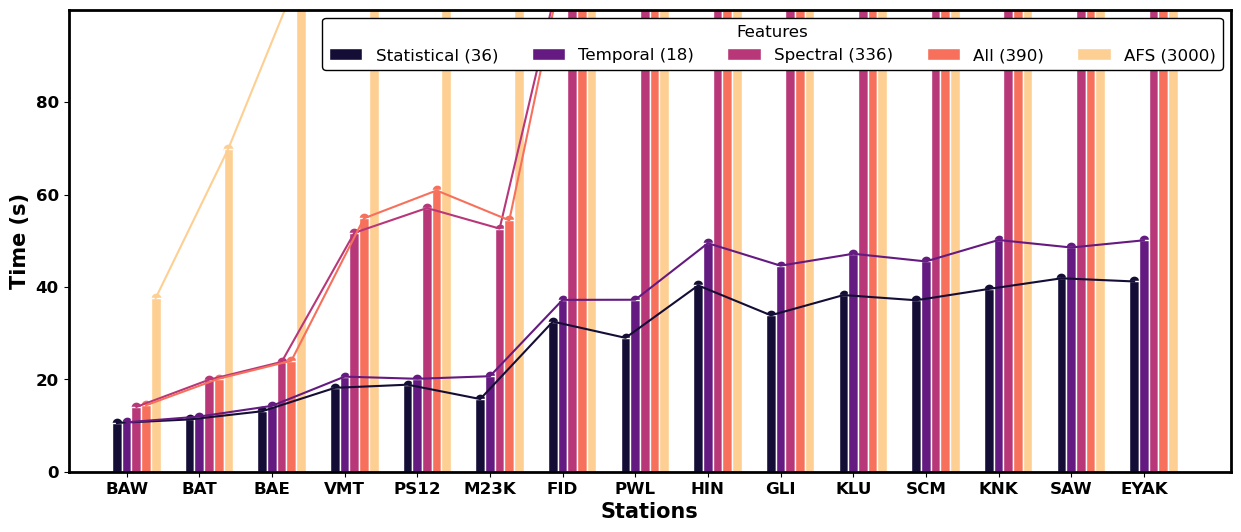

In [284]:
a1 = np.array(dur_stat)*100
a2 = np.array(dur_temp)*100
a3 = np.array(dur_spec)*100
a4 = np.array(dur_all)*100
a5 = np.array(dur_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
import numpy as np
import matplotlib.pyplot as plt


import matplotlib

cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, a1[order], color =c1, width = barWidth,
        label ='Statistical (36)',edgecolor='w')
plt.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal (18)',edgecolor='w')
plt.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral (336)',edgecolor='w')
plt.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All (390)',edgecolor='w')
plt.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS (3000)',edgecolor='w')


v = np.vstack((a1[order],a2[order]))
X = [br1, br2]
c= [c2,c5]
#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


plt.scatter(br1, a1[order], color=c1)
plt.scatter(br2, a2[order], color=c2) 
plt.scatter(br3, a3[order], color=c3) 
plt.scatter(br4, a4[order], color=c4) 
plt.scatter(br5, a5[order], color=c5) 

plt.plot(br1, a1[order], color=c1)
plt.plot(br2, a2[order], color=c2) 
plt.plot(br3, a3[order], color=c3)
plt.plot(br4, a4[order], color=c4)
plt.plot(br5, a5[order], color=c5)

# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.ylabel('Time (s)', fontweight ='bold', fontsize = 15)
plt.yticks(np.arange(0,100,20), fontweight = 'bold', fontsize=12)
plt.xticks([1.5*r + barWidth for r in range(len(a1))],stations[order], fontsize= 12, fontweight='bold')
plt.ylim(0,100)
plt.xlim(-1,23)
plt.legend(loc='upper right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, title ='Features', title_fontsize=12)
#plt.show()

#plt.savefig('Manuscript_Figures/Features_Performance_Comparison_averaged.eps')








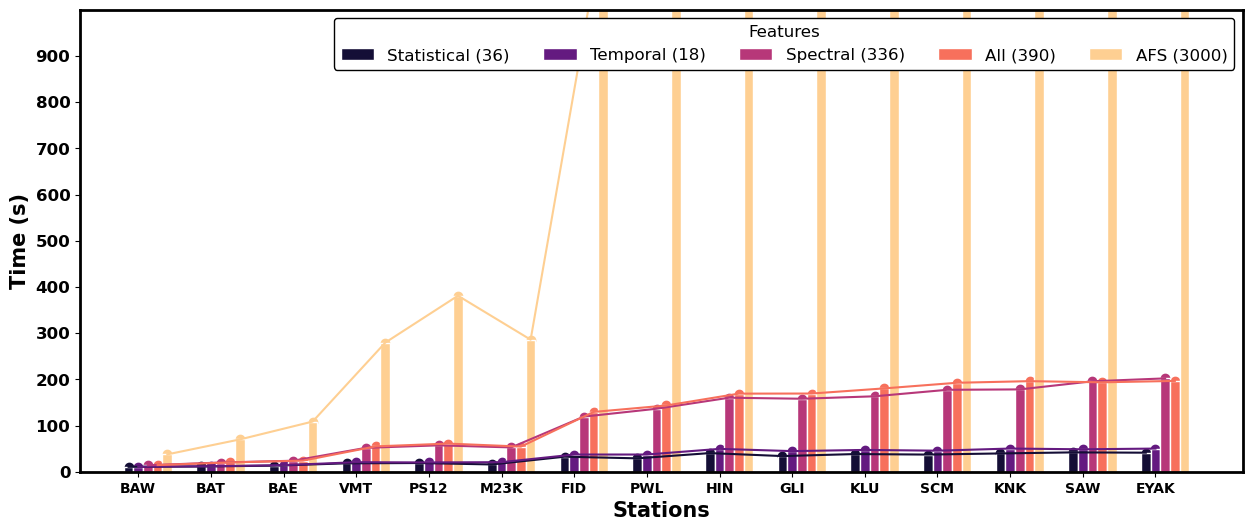

In [285]:
a1 = np.array(dur_stat)*100
a2 = np.array(dur_temp)*100
a3 = np.array(dur_spec)*100
a4 = np.array(dur_all)*100
a5 = np.array(dur_afs)*100



plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
import numpy as np
import matplotlib.pyplot as plt


import matplotlib

cmap = matplotlib.cm.get_cmap('magma')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, a1[order], color =c1, width = barWidth,
        label ='Statistical (36)',edgecolor='w')
plt.bar(br2, a2[order], color =c2, width = barWidth,
         label ='Temporal (18)',edgecolor='w')
plt.bar(br3, a3[order], color =c3, width = barWidth,
         label ='Spectral (336)',edgecolor='w')
plt.bar(br4, a4[order], color =c4, width = barWidth,
         label ='All (390)',edgecolor='w')
plt.bar(br5, a5[order], color =c5, width = barWidth,
         label ='AFS (3000)',edgecolor='w')


v = np.vstack((a1[order],a2[order]))
X = [br1, br2]
c= [c2,c5]
#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


plt.scatter(br1, a1[order], color=c1)
plt.scatter(br2, a2[order], color=c2) 
plt.scatter(br3, a3[order], color=c3) 
plt.scatter(br4, a4[order], color=c4) 
plt.scatter(br5, a5[order], color=c5) 

plt.plot(br1, a1[order], color=c1)
plt.plot(br2, a2[order], color=c2) 
plt.plot(br3, a3[order], color=c3)
plt.plot(br4, a4[order], color=c4)
plt.plot(br5, a5[order], color=c5)

# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)

plt.ylabel('Time (s)', fontweight ='bold', fontsize = 15)
plt.yticks(np.arange(0,1000,100), fontweight = 'bold', fontsize=12)
plt.xticks([1.5*r + barWidth for r in range(len(a1))],stations[order], fontweight='black')
plt.ylim(0,1000)
plt.xlim(-1,23)
plt.legend(loc='upper right',ncol=5, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, title ='Features', title_fontsize=12)
#plt.show()

#plt.savefig('Manuscript_Figures/Features_Performance_Comparison_averaged.eps')






